Jean-Louis DU / 28706249 \
Wassim TAHER / 28705837

# <font color=steelblue>Gauss Tronquée</font>

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.stats import norm
from scipy.stats import multivariate_normal
rng = default_rng()

## <font color = "orange"> Introduction </font>

L'objectif de ce projet est de réussir à simuler des gaussiennes tronquées par méthode de rejet, ici on va seulement s'intéresser à la troncature sur les parties postives de chaque composantes.

Pour commencer, on a que la densité d'une Gaussienne en dimension n de moyenne $\mu$ et de matrice de covariance $\Sigma$ (symétrique et défini positive) s'écrit comme ceci :
$$\phi(\mathbf{x} | \mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}} |\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})\right)
$$

In [10]:
def f1(x,mu1, sig1):
    """ Densité de la loi normale de moyenne mu1 et de variance sig1 """
    return norm.pdf(x, loc=mu1, scale=sig1)

def fn(x, mun, sign):
    """ Cette fois x dans Rn, mun dans Rn et sign matrice nxn """
    return multivariate_normal.pdf(x, mun, sign)

## <font color = "orange"> Trouver la constante de renomarlisation </font>

Lors de la méthode de rejet on aura besoin de savoir évaluer la densité tronquée en un point, on va donc chercher à l'exprimer explicitement.

$$f(\mathbf{x} ;\mathbf{\mu}, \Sigma) = \frac{\phi(\mathbf{x} ; \mathbf{\mu}, \Sigma)}{C}\mathbb{1}_{\mathbb{R}^n_+}(\mathbf{x})
$$

Avec C une constante de renormalisation de sorte à ce que $f$ soit une densité.

En passant à l'intégrale sur $\mathbb{R}^n$ et en constatant que $f$ défini une densité,  on obtient 
$$ C = \int_{\mathbb{R}^n_+} \phi(\mathbf{x}) d\mathbf{x} $$

Or on ne sait pas calculer cette quantité explicitement, on va donc utiliser un Monte-Carlo avec de l'importance sampling afin de calculer cette constante de renormalisation.

$$ \int_{\mathbb{R}_+^{n}} \phi(\mathbf{x}) d\mathbf{x} = \int \mathbb{1}_{\mathbb{R}_+^{n}}(\mathbf{x}) \phi(\mathbf{x}) d\mathbf{x} $$
$$ = \int \mathbb{1}_{\mathbb{R}_+^{n}}(\mathbf{x}) \frac{\phi(\mathbf{x})}{\phi_{\theta}(\mathbf{x})} \phi_{\theta}(\mathbf{x}) d\mathbf{x}$$ avec $\phi_{\theta}(\mathbf{x} ; \mathbf{\mu}, \sigma) = \frac{1}{(2\pi)^{\frac{n}{2}} |\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{\mu} -\theta)^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu} - \theta)\right)$
$$ = \mathbb{E}_{\theta}\left[\mathbb{1}_{\mathbb{R}_+^{n}}(\mathbf{x}) \frac{\phi(\mathbf{x})}{\phi_{\theta}(\mathbf{x})} \right]$$
$$ = \mathbb{E}_{\theta}\left[\mathbb{1}_{\mathbb{R}_+^{n}}(\mathbf{x}) \exp\left( - \langle \mathbf{x}-\mathbf{\mu} ,\Sigma^{-1}\theta \rangle+\frac{1}{2}\langle\theta,\Sigma^{-1}\theta\rangle \right)\right]$$

On choisi $\theta_i = max(-\mu_i, 0) \quad \forall i \quad$ de sorte à ce que la probabilité soit meilleure que l'estimateur classique.

In [11]:
def mc1(mu1, sig1, size = 10000):
    """ Monte Carlo en dimension 1 par importance sampling """
    mu1_bis = max(mu1, 0)
    teta = max(-mu1, 0)
    sample = np.random.normal(mu1_bis, sig1, size)
    res1 = sample>0
    res2 = np.exp(-(sample-mu1)*teta/sig1 + 0.5*teta*teta/sig1)
    return np.mean(res1*res2)

def mcn(mun, sign, size = 10000):
    """ Monte Carlo avec importance sampling pour déterminer la constante de renormalisation """
    mun_bis = np.maximum(mun, 0)
    teta = np.maximum(-mun, 0)
    invsign = np.linalg.inv(sign)
    sample = np.random.multivariate_normal(mun_bis, sign, size)
    res1 = np.all(sample>=0, axis=1)
    res2 = np.exp(-(sample-mun)@invsign@teta + 0.5*teta@invsign@teta)
    return np.mean(res1*res2)

def f_tronc1(x, mu1, sig1, c1):
    """ En dimension 1 dans notre étude on tronque la partie négative """
    if x < 0:
        return 0
    else :
        return f1(x, mu1, sig1)/c1

## <font color = "orange"> Choisir g et déterminer le taux d'acceptation </font>

Maintenant on sait évaluer la loi tronquée.
La prochaine question à se poser est quelle est le choix de g ? \
On rappelle que l'on veut g une densité tel que $$\exists D > 0  \quad \text{tq } \quad f(\mathbf{x}) \le Dg(\mathbf{x})$$ \
Le taux d'acceptation vaut $1/D$.

### <font color = "green">En dimension 1 </font> 
On peut prendre g une gaussienne de même variance et de moyenne $\mu = \max(\mu, 0)$. \
Ainsi si $\mu \geq 0 \quad \text{alors} \quad D = 1/C$ \
et si $\mu \leq 0 \quad \text{alors} \quad\frac{f}{g}(x) = \frac{1}{C}\exp\left(-\frac{\mu^2-2\mu x}{2 \sigma^2}\right)\mathbb{1}_{\mathbb{R}^+}(x) \leq \frac{1}{C}\exp(\frac{-\mu^2}{2 \sigma^2}) = D$


In [12]:
def trouver_d1(mu1, sig1, c1):
    """ Trouver l'inverse du taux d'acceptation en dim 1 """
    mu1_t = max(0,mu1)
    return np.exp(-(mu1-mu1_t)**2/(2*sig1**2))/c1  

def g1_d(x, mu1, sig1, d1):
    """ On regarde la valeur de mu1 """
    mu1_t = max(0,mu1)
    return f1(x, mu1_t, sig1)*d1

### <font color = "green">En dimension n </font> 
Soit $ \tilde{\mu} \in \mathbb{R}^n $, $\widetilde{\Sigma} \in \mathbb{R}^{n \times n}$, on a : 
\begin{equation*}
g(\mathbf{x}; \mathbf{\tilde{\mu}}, \widetilde{\Sigma}) = \frac{1}{(2\pi)^{\frac{n}{2}}|\widetilde{\Sigma}|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}(\mathbf{x} - \mathbf{\tilde{\mu}})^T \widetilde{\Sigma}^{-1} (\mathbf{x} - \mathbf{\tilde{\mu}})\right)
\end{equation*}
Ainsi, soit C la constante de normalisation de $f$ et, 
\begin{equation*}
f(\mathbf{x}; \mathbf{\mu}, \Sigma) = \frac{1}{C(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})\right)\mathbb{1}_{\mathbb{R}^n_+}(\mathbf{x})
\end{equation*}
Ainsi, on obtient le rapport suivant,
\begin{equation*}
\frac{f(\mathbf{x}; \mathbf{\mu}, \Sigma)}{g(\mathbf{x}; \mathbf{\tilde{\mu}}, \widetilde{\Sigma})} = \frac{\exp\left(-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})\right)\mathbb{1}_{\mathbb{R}^n_+}(\mathbf{x})}{C\exp\left(-\frac{1}{2}(\mathbf{x} - \mathbf{\tilde{\mu}})^T \widetilde{\Sigma}^{-1} (\mathbf{x} - \mathbf{\tilde{\mu}})\right)}
\end{equation*}
\begin{equation*}
\frac{f(\mathbf{x}; \mathbf{\mu}, \Sigma)}{g(\mathbf{x}; \mathbf{\tilde{\mu}}, \widetilde{\Sigma})} = \frac{\exp\left(-\frac{1}{2}\left((\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) - (\mathbf{x} - \mathbf{\tilde{\mu}})^T \widetilde{\Sigma}^{-1} (\mathbf{x} - \mathbf{\tilde{\mu}})\right)\right)\mathbb{1}_{\mathbb{R}^n_+}(\mathbf{x})}{C}
\end{equation*}
Concentrons nous sur la partie exponentielle de l'équation, introduisons la notation, 

\begin{equation*}
(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})= \|\mathbf{x} - \mathbf{\mu}\|_{\Sigma^{-1}}^2 = \|\mathbf{x} \|_{\Sigma^{-1}}^2 +\|\mathbf{\mu}\|_{\Sigma^{-1}}^2\ -2\langle \mathbf{x}, \Sigma^{-1}\mathbf{\mu} \rangle
\end{equation*}

Ainsi en couplant tous, on obtient, 
\begin{equation*}
-\frac{1}{2}\left(\|\mathbf{x} \|_{\Sigma^{-1}}^2 +\|\mathbf{\tilde{\mu}}\|_{\Sigma^{-1}}^2\ -2\langle \mathbf{x}, \Sigma^{-1}\mathbf{\mu} \rangle - \|\mathbf{x} \|_{\widetilde{\Sigma}^{-1}}^2 -\|\mathbf{\tilde{\mu}}\|_{\widetilde{\Sigma}^{-1}}^2 +2\langle \mathbf{x}, \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}} \rangle
    \right)
\end{equation*}
Finalement, en revenant à l'équation initial on trouve, 
\begin{equation*}
 \frac{f(\mathbf{x}; \mathbf{\mu}, \Sigma)}{g(\mathbf{x}; \mathbf{\tilde{\mu}}, \widetilde{\Sigma})} = \frac{\exp(-\frac{1}{2}\left(\|\mathbf{x} \|_{\Sigma^{-1}}^2 +\|\mathbf{\mu}\|_{\Sigma^{-1}}^2\ -2\langle \mathbf{x}, \Sigma^{-1}\mathbf{\mu} \rangle - \|\mathbf{x} \|_{\widetilde{\Sigma}^{-1}}^2 -\|\mathbf{\tilde{\mu}}\|_{\widetilde{\Sigma}^{-1}}^2 +2\langle \mathbf{x}, \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}} \rangle
    \right))}{C}   \\ \\ \\ 
\end{equation*}
\begin{equation*}
\frac{f(\mathbf{x}; \mathbf{\mu}, \Sigma)}{g(\mathbf{x}; \mathbf{\tilde{\mu}}, \widetilde{\Sigma})} =\frac{\exp(-\frac{1}{2}\left(\|\mathbf{\mu}\|_{\Sigma^{-1}}^2\ -\|\mathbf{\tilde{\mu}}\|_{\widetilde{\Sigma}^{-1}}^2 \right))}{C}\exp(-\frac{1}{2}|\mathbf{x} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}^2 + 2\langle \mathbf{x}, (\Sigma^{-1}\mathbf{\mu} - \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}}) \rangle)
\end{equation*}
Ainsi, pour majoré ce terme en sachant que $x \in \mathbb{R}^n_+$, il suffit juste donc de remplir deux condition : 
1. **Condition 1** : $\Sigma^{-1}-\widetilde{\Sigma}^{-1}$ est semi défini positif, ce qui nous assure que $-\frac{1}{2}|\mathbf{x} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}^2 \leq |\mathbf{0} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}$

2. **Condition 2** : Soit $v = \Sigma^{-1}\mathbf{\mu}$ et $\tilde{v} = \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}}$, on doit donc avoir $\forall i \in \{1, 2, \ldots, n\}$ $v_i \leq \tilde{v}_i$

On peut donc distinguer deux cas qui seront traités séparément :

   - **Cas 1 :** Si $\Sigma$ est diagonale, alors $\Sigma^{-1}$ est également diagonale et n'a donc que des valeurs positives.

   - **Cas 2 :** Si $\Sigma^{-1}$ n'est pas diagonale.

Concernant le cas 1, on peut donc choisir $ \widetilde{\Sigma} = \Sigma $ ce qui implique de choisir, \begin{equation*}
    (\tilde{\mu}_i)_{1\leq i\leq n} = \begin{cases} 0, & \text{si } \mu_i < 0 \\ \mu_i, & \text{sinon}\end{cases}
\end{equation*}
Ainsi, il en résulte que, 
\begin{equation*}
    \arg\max_{x \in \mathbb{R}^n_+} \exp(-\frac{1}{2}|\mathbf{x} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}^2 + 2\langle \mathbf{x}, (\Sigma^{-1}\mathbf{\mu} - \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}}) \rangle) = \mathbf{0}_n
\end{equation*}
Et donc, vu que $\exp(0) = 1$, on a, 
\begin{equation*}
    D = \frac{\exp(-\frac{1}{2}\left(\|\mathbf{\mu}\|_{\Sigma^{-1}}^2\ -\|\mathbf{\tilde{\mu}}\|_{\widetilde{\Sigma}^{-1}}^2 \right))}{C}
\end{equation*}

In [13]:
def trouver_dn(mun, sign, cn):
    """ Trouver l'inverse du taux d'acceptation en dim n """
    mun_t = np.maximum(mun, 0)
    inv_sign = np.linalg.inv(sign)
    res = np.exp(-0.5*mun@inv_sign@mun + 0.5*mun_t@inv_sign@mun_t)/cn
    return res

Concernant le second cas, posons $\widetilde{\Sigma}^{-1} = {\Sigma}^{-1}-\lambda I_n $, ce qui peut assurer la condition 1. Cependant, $\widetilde{\Sigma}^{-1}$ doit rester symétrique et définie positif, donc on choisit $\lambda$ strictement inférieur à la plus petite valeur propre de $\Sigma$ qu'on appellera $\lambda_{\min}$. Concernant la condition 2, on remarque que $ \forall i \in \{1, 2, \ldots, n\}$ $v_i\leq \tilde{v}_i$ revient à résoudre via "np.solve".\
Par ailleurs, dans tout les cas on peut choisir $\widetilde{\Sigma} = \Sigma$ et $\tilde{\mu} = \mu$, ce qui revient à prendre
\begin{equation*}
    \tilde{D} = \frac{1}{C}
\end{equation*}

9.198052217737939e-36

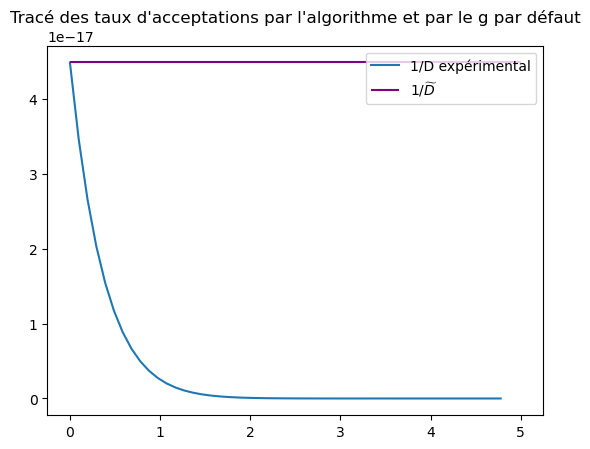

In [24]:
def trouver_dnbis(mun, sign, cn):
    """ """
    inv_sign = np.linalg.inv(sign)
    lambd = np.min(np.linalg.eigvals(inv_sign))-0.1
    list_l = np.linspace(0, lambd)
    R = []
    for l in list_l:
        inv_sign_bis = inv_sign - l*np.eye(len(mun))
        V = inv_sign@mun
        mu_bis = np.linalg.solve(inv_sign_bis,V)
        res = np.sqrt(1/(np.linalg.det(inv_sign_bis)*np.linalg.det(sign)))*np.exp(-mun@inv_sign@mun/2 + mu_bis@inv_sign_bis@mu_bis/2)/cn
        res2 = 1/cn
        R.append(1/res)
    plt.plot(list_l, R, label="1/D expérimental")
    plt.hlines(1/res2, 0, 5, color = "purple", label = r"$1/\widetilde{D}$")
    plt.legend()
    plt.title("Tracé des taux d'acceptations par l'algorithme et par le g par défaut")
    return 1/res
    
mu_test = np.array([-2, -1])
sig_test = np.array([[0.125,-0.0625],[-0.0625, 0.15625]])
cn_test = mcn(mu_test, sig_test)

trouver_dnbis(mu_test, sig_test, cn_test)

Il y a deux observations importantes. Dans le premier cas, notre solution $D$ est meilleure que $\tilde{D}$. Cependant, on observe que dans le second cas, plus $\lambda$ est proche de 0, plus $D$ est proche de $\tilde{D}$ car $\widetilde{\Sigma}$ est proche de $\Sigma$ et donc $\tilde{\mu}$ de $\mu$. De plus, si $\lambda$ s'approche de $\lambda_{\min}$, la méthode de rejet devient de plus en plus inefficace.

## <font color = "orange">Ouverture </font>
On peut s'intéresser au cas où une loi gaussienne serai tronqué sur $]-\infty, 0]$, la condition 1 resterai la même et la condition 2 deviendrai : $v = \Sigma^{-1}\mathbf{\mu}$ et $\tilde{v} = \widetilde{\Sigma}^{-1}\mathbf{\tilde{\mu}}$, on doit donc avoir $ \forall i \in \{1, 2, \ldots, n\}$ $  v_i \geq \tilde{v}_i$. Le raisonnement utiliser précédemment reste donc le même tout comme les résultats. \
Concernant le cas où on aurai $a$ et $b$, tel que la loi gaussienne serai tronquée sur $[a, b]$. Donc, $\arg\max_{x \in \mathbb{R}^n_+} $ n'est plus forcement $\mathbf{0}_n$ en fonction de $a$ et $b$. En effet, si nous choissons $\widetilde{\Sigma}^{-1}$,$\mathbf{\tilde{\mu}}$ respectant les conditions 1 et 2, dont la deuxième dépendent du signe de $a$ et $b$. \
En effet, grâce à la condition 2 il ne reste plus que $  \exp(-\frac{1}{2}|\mathbf{x} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}^2 )$ à maximiser. \
Ainsi, si a et b sont tout deux positifs ou négatifs, on a que la solution est $\arg\max_{x \in \mathbb{R}^n_+} $ = $\min(\lvert a \rvert, \lvert b \rvert)_n$ qu'on notera $\tilde{x}$, si a et b sont de signes opposés $\tilde{x}=0$, et donc, 
\begin{equation*}
D = \frac{\exp(-\frac{1}{2}\left(\|\mathbf{\mu}\|_{\Sigma^{-1}}^2\ -\|\mathbf{\tilde{\mu}}\|_{\widetilde{\Sigma}^{-1}}^2 + |\mathbf{\widetilde{x}} \|_{(\Sigma^{-1}-\widetilde{\Sigma}^{-1})}^2\right)) }{C}
\end{equation*}

# <font color="steelblue">Exemple et représentation en dimension 1</font>

Taux d'accepatations :    0.8828999999999999  ///  0.11387951815958314


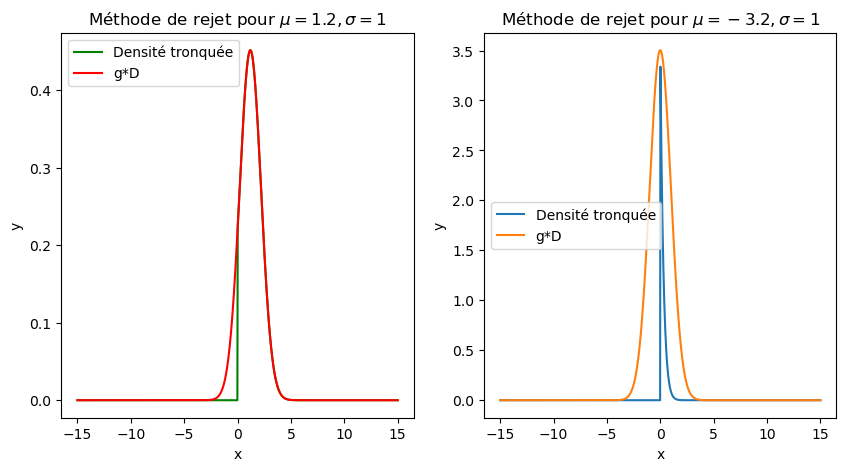

In [15]:
# Data test
m1 = -3.2
m1_bis = 1.2
s1 = 1

const_1 = mc1(m1, s1)
const_1bis = mc1(m1_bis, s1)
d1 = trouver_d1(m1, s1, const_1)
d1bis = trouver_d1(m1_bis, s1, const_1bis)

# Tracés et affichage

x = np.linspace(-15,15,1000)

print("Taux d'accepatations :   ", 1/d1bis, " /// ", 1/d1)

y1 = [f_tronc1(i, m1_bis, s1, const_1bis) for i in x]
y2 = [g1_d(i, m1_bis, s1, d1bis) for i in x]
y3 = [f_tronc1(i, m1, s1, const_1) for i in x]
y4 = [g1_d(i, m1, s1, d1) for i in x]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

ax1.plot(x,y1, label="Densité tronquée", color = "green")
ax1.plot(x,y2, label="g*D", color = "red")
ax1.legend()
ax1.set_title(rf"Méthode de rejet pour $\mu = {m1_bis}, \sigma = {s1}$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(x,y3, label="Densité tronquée")
ax2.plot(x,y4, label="g*D")
ax2.legend()
ax2.set_title(rf"Méthode de rejet pour $\mu = {m1}, \sigma = {s1}$")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()

# <font color = "steelblue"> Evolution du pourcentage de rejet en fonction de la dimension

In [16]:
def fonction_ultime_gauss_diag(n, size = 100):
    """ On lui donne juste la dimension n 
        Cas où les covariances sont diagonales """
    if n == 1:
        mus = rng.uniform(-5, 5, size = size)
        sigmas = rng.uniform(1,5, size = size)
        c = [mc1(mus[i], sigmas[i]) for i in range(size)]
        d = [trouver_d1(mus[i], sigmas[i], c[i]) for i in range(size)]
        taux = np.mean(1/np.array(d))
        print("Dimension : ",n, " -> Taux d'acceptation : ", taux)
        return taux
        
    elif n>1 :
        idn = np.eye(n)
        mus = rng.uniform(-5,5, size = (size,n))
        sigmas = rng.uniform(1,5,size = (size, n))
        sigmas = [np.diag(sigmas[i]) for i in range(size)]
        c = [mcn(mus[i], sigmas[i]) for i in range(size)]
        d = [trouver_dn(mus[i], sigmas[i], c[i]) for i in range(size)]
        taux = np.mean(1/np.array(d))
        print("Dimension : ",n , " -> Taux d'acceptation : ", taux)
        return taux

Dimension :  1  -> Taux d'acceptation :  0.44037067034873856
Dimension :  2  -> Taux d'acceptation :  0.2976618110845937
Dimension :  3  -> Taux d'acceptation :  0.14485498664539256
Dimension :  4  -> Taux d'acceptation :  0.10489159345955189
Dimension :  5  -> Taux d'acceptation :  0.060959417536223935
Dimension :  6  -> Taux d'acceptation :  0.024130456911811034
Dimension :  7  -> Taux d'acceptation :  0.013275082228499597
Dimension :  8  -> Taux d'acceptation :  0.010906852478815949
Dimension :  9  -> Taux d'acceptation :  0.006597105717650435
Dimension :  10  -> Taux d'acceptation :  0.002587826027958258
Dimension :  11  -> Taux d'acceptation :  0.0014468146650250101
Dimension :  12  -> Taux d'acceptation :  0.0002021023827551852
Dimension :  13  -> Taux d'acceptation :  0.0005932981368476512
Dimension :  14  -> Taux d'acceptation :  0.00037647891722921133


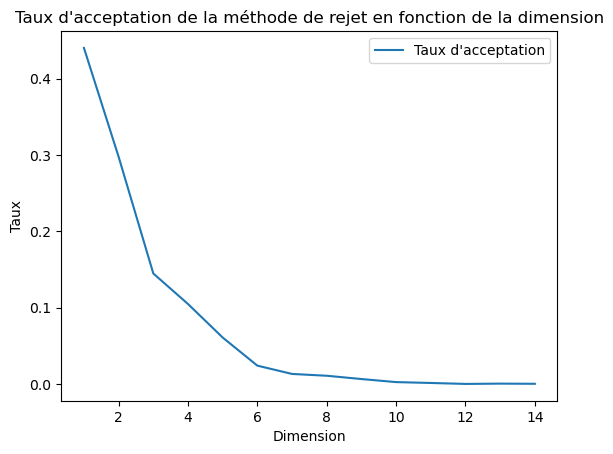

In [17]:
# Plot
list_dim = np.arange(1, 15)
taux_dim_diag = [fonction_ultime_gauss_diag(i) for i in list_dim]

plt.plot(list_dim, taux_dim_diag, label = "Taux d'acceptation")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Taux")
plt.title("Taux d'acceptation de la méthode de rejet en fonction de la dimension")
plt.show()

In [18]:
def Sigma(n):
    """ Renvoie une matrice symétrique définie positive 
        On a fixer des valeurs maximales pour que les composantes de diag et P ne soient pas trop grands
        Libre de de les modifier si on veut """ 
    diag = np.random.uniform(0.1,5,size=n)
    P = np.random.uniform(-3,3,size=(n,n))
    return P@np.diag(diag)@P.T

In [19]:
def fonction_ultime_gauss(n, size = 100):
    """ On lui donne juste la dimension n """
    if n == 1:
        mus = rng.uniform(-5, 5, size = size)
        sigmas = rng.uniform(1,5, size = size)
        c = [mc1(mus[i], sigmas[i]) for i in range(size)]
        taux = np.mean(c)
        print("Dimension : ",n, " -> Taux d'acceptation : ", taux)
        return taux
        
    elif n>1 :
        idn = np.eye(n)
        mus = rng.uniform(-5,5, size = (size,n))
        sigmas = [Sigma(n) for _ in range(size)]
        c = [mcn(mus[i], sigmas[i]) for i in range(size)]
        taux = np.mean(c)
        print("Dimension : ",n , " -> Taux d'acceptation : ", taux)
        return taux

Dimension :  1  -> Taux d'acceptation :  0.414062088946535
Dimension :  2  -> Taux d'acceptation :  0.2069265394259273
Dimension :  3  -> Taux d'acceptation :  0.1053419099540291
Dimension :  4  -> Taux d'acceptation :  0.06384095604309004
Dimension :  5  -> Taux d'acceptation :  0.02054222966945864
Dimension :  6  -> Taux d'acceptation :  0.014996202097878055
Dimension :  7  -> Taux d'acceptation :  0.007528337530945667
Dimension :  8  -> Taux d'acceptation :  0.002792908641602923
Dimension :  9  -> Taux d'acceptation :  0.0013024803706913814
Dimension :  10  -> Taux d'acceptation :  0.0005388554589423647
Dimension :  11  -> Taux d'acceptation :  0.00033350079108619723
Dimension :  12  -> Taux d'acceptation :  0.00011201423821338198
Dimension :  13  -> Taux d'acceptation :  0.00010689187618705193
Dimension :  14  -> Taux d'acceptation :  9.600326304185677e-06


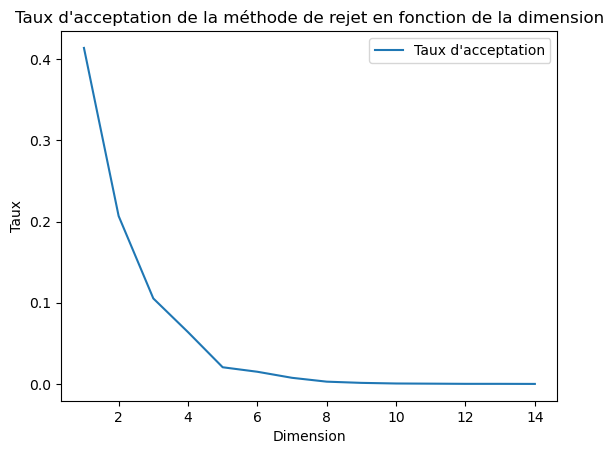

In [20]:
# Plot
taux_dim = [fonction_ultime_gauss(i) for i in list_dim]

plt.plot(list_dim, taux_dim, label = "Taux d'acceptation")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Taux")
plt.title("Taux d'acceptation de la méthode de rejet en fonction de la dimension")
plt.show()

# <font color = "steelblue"> Limite </font>

Si on se place dans le cas où l'espace tronqué est proche de $[-\infty, \infty]$ la méthode de rejet n'est pas très efficace étant donné que la constante de renormalisation est très proche de 1. \
Dans le cas général on remarque que plus la dimension augmente plus la méthode de rejet est inefficace. 

# <font color = "darkviolet"> Conclusion : L'efficacité de la méthode de rejet diminue avec l'augmentation de la dimension </font> 